mus: [[7.57217372 3.99159933 6.20403943 2.27387381]
 [7.54329912 3.54795108 6.6217683  0.19672925]
 [5.96924669 2.48955933 4.98321255 2.44360167]]
mus: [array([[6.91516588, 3.0984801 , 5.69646993, 2.00545376]]), array([[6.84565471, 3.00281125, 5.51148607, 1.79516817]]), array([[5.62883021, 3.04889271, 3.3732846 , 1.04366631]])]
mus: [array([[6.80886864, 3.0860563 , 5.61745664, 2.04291515]]), array([[6.76989626, 2.94243519, 5.43214961, 1.74411309]]), array([[5.56213177, 3.05254682, 3.22342239, 0.96745051]])]
mus: [array([[6.72193981, 3.07933809, 5.57468177, 2.06474984]]), array([[6.66694435, 2.88005999, 5.34369979, 1.66917094]]), array([[5.50341179, 3.06070269, 3.06586825, 0.89209161]])]
mus: [array([[6.62648293, 3.06358939, 5.51835279, 2.06958213]]), array([[6.63005454, 2.86533419, 5.27495762, 1.62142394]]), array([[5.45312878, 3.07553653, 2.91526616, 0.82473081]])]
mus: [array([[6.53075749, 3.04556633, 5.46099904, 2.06783438]]), array([[6.61627036, 2.87446421, 5.19882801, 1.5873207 ]]

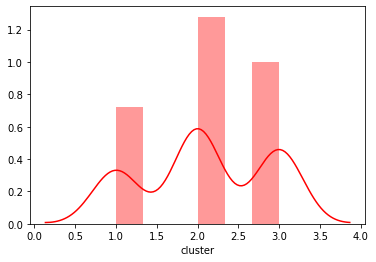

In [1]:
import math
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import os

import matplotlib.pyplot as plt


def expectation_maximization(dataset, k, eps, max_iteration=50):
    """
    Expectation Maximization algorithm implementation from chapter 13
    :param dataset:
    :param k:
    :param eps:
    :return:
    """
    d = dataset.shape[1]
    t = 0
    sigmai = np.identity(d)
    ck, mus, sigmas = init_para(k, d, sigmai, dataset)

    wij = np.array(np.zeros((k, dataset.shape[0])))

    while True:
        t += 1
        wij, ck_new, mus_new, sigmas_new = perform_iteration(dataset, ck, mus, sigmas)
        print("mus:", mus)
        if t > max_iteration or (t > 1 and get_diff_mus(mus_new, mus, k, d) <= eps):
            break
        ck = ck_new
        mus = mus_new
        sigmas = sigmas_new
    print("Final Mus:", mus)
    print("Final Covariance:", sigmas)
    print("No of. Iterations:", t)
    df = pd.DataFrame(wij)
    df["cluster"] = df.apply(lambda row: find_max_prob(row), axis=1)
    print(df)
    print(df.groupby(by="cluster").count())

    ax = sns.distplot(df.cluster, color = 'red')



def find_max_prob(row):
    max = row.max()
    for i in range(len(row)):
        if max == row[i]:
            return i + 1


def get_diff_mus(mus_new, mus, k, d):
    sum = 0
    for i in range(k):
        diffij = mus_new[i] - mus[i]
        sum += diffij.sum() ** 2
    return sum


def init_para(k, d, sigmai, dataset):
    ck = np.array(np.ones((k, 1))) * (1 / float(k))
    mus = initMus(d, k, dataset)
    sigmas = []
    for i in range(k):
        sigmas.append(sigmai)
    return ck, mus, sigmas


def calculate_cluster_probability(X, mu, variance):
    dim = np.shape(X)[0]
    # print dim
    pi = math.pi
    exp = np.exp

    X = np.mat(X)
    mu = np.mat(mu)
    tmp = X - mu

    variance = np.mat(variance)
    # print variance
    deter = np.linalg.det(variance)
    # deter = 1
    tmp0 = np.linalg.pinv(variance)
    tmp1 = tmp * tmp0 * tmp.transpose()
    # print tmp0,tmp1,deter,dim
    prob = 1 / (((2 * pi) ** (dim / 2)) * (deter ** 0.5)) * exp(-0.5 * tmp1)
    # print prob
    return prob


def perform_iteration(X, pi, mu, sigma):
    num, dim = np.shape(X)
    c, notused = np.shape(pi)
    k = len(mu)
    Nk = np.array(np.zeros((k, 1)))
    wij = np.array(np.zeros((num, k)))
    sigma_new = []
    mu_new = []
    pi_new = np.array(np.zeros((c, 1)))
    for i in range(num):
        total = 0
        for j in range(k):
            wij[i, j] = pi[j] * calculate_cluster_probability(X[i], mu[j], sigma[j])
            total += wij[i, j]
        for j in range(k):
            wij[i, j] = wij[i, j] / total
    # print 'wij',wij,'\n'

    for j in range(k):
        tmp_mu = np.array(np.zeros((1, dim)))
        #
        for i in range(num):
            Nk[j, 0] += wij[i, j]
            tmp_mu += wij[i, j] * X[i]
        mu_new.append(tmp_mu / Nk[j, 0])
    # print 'mu_new',mu_new,'\n'

    for j in range(k):
        tmp_var = np.array(np.zeros((dim, dim)))
        for i in range(num):
            tmp_var += wij[i, j] * (
                    (X[i] - mu_new[j]).transpose() * (X[i] - mu_new[j]))
        sigma_new.append(tmp_var / Nk[j, 0])
    # print 'sigma_new',sigma_new,'\n'

    for j in range(k):
        pi_new[j] = Nk[j] / num
    # print 'pi_new',pi_new,'\n'

    return wij, pi_new, mu_new, sigma_new


def initMus(d, k, dataset):
    """
    Initialize mus(centroids for clusters) for k clusters with d dimension for dataset
    :param d:
    :param k:
    :param dataset:
    :return: mus as dataframe
    """
    data = pd.DataFrame(dataset)
    mins = data.min()
    maxs = data.max()
    mus = []
    for i in range(d):
        mus.append([xs for xs in np.random.uniform(mins[i], maxs[i], k)])
    mu = pd.DataFrame(mus)
    mu = mu.transpose()
    return np.array(mu)


def main():
    dataset = pd.read_csv("iris.csv", header=None, names=["x1", "x2", "x3", "x4", "x5"])
    dataset.drop(labels=["x5"], inplace=True, axis=1)
    expectation_maximization(np.array(dataset), 3, 0.001)

    # dataset = np.array([[1.0], [1.3], [2.2], [2.6], [2.8], [5.0], [7.3], [7.4], [7.5], [7.7], [7.9]])
    # expectation_maximization(dataset, 2, 0.0001)

main()
